# Finding the Lyapunov Function using Counterexamples Method

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from scipy.linalg import solve_continuous_lyapunov
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from dreal import *

import timeit 

import tqdm
import copy

## Obtaining the Trajectories

In [14]:
import scipy.io
# Training Data
mat = scipy.io.loadmat('../LASA_Dataset/lasahandwritingdataset/Angle_train.mat')
datat = mat['Data']
datat = np.transpose(datat)
# Getting the Position and Velocity Seperately
X_train = datat[:,:2]
y_train = datat[:,2:]
# Testing Data
mat = scipy.io.loadmat('../LASA_Dataset/lasahandwritingdataset/Angle_test.mat')
data = mat['Data']
data = np.transpose(data)
# Getting the Position and Velocity Seperately
X_test = data[:,:2]
y_test = data[:,2:]
# Validation Data
mat = scipy.io.loadmat('../LASA_Dataset/lasahandwritingdataset/Angle_val.mat')
data = mat['Data']
data = np.transpose(data)
# Getting the Position and Velocity Seperately
X_val = data[:,:2]
y_val = data[:,2:]
# dt
dt = 0.0030


### NORMALISE THE TRAJECTORIES
X_train /= 40
X_test /= 40
X_val /= 40
y_train /= 40
y_test /= 40
y_val /= 40

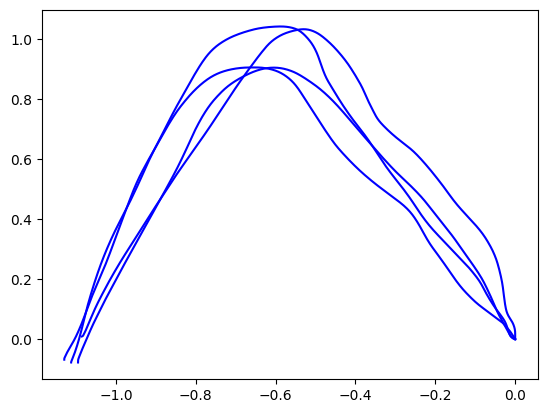

In [15]:
# Plotting the Training Data
fig, ax = plt.subplots()
n = int(X_train.shape[0]/1000)
for i in range(5):
    ax.plot(X_train[(i-1)*1000+1:i*1000,0], X_train[(i-1)*1000+1:i*1000,1],"b")
plt.show()

## Neural Network

In [16]:
## NN for learning the Lyapunov Function
class Net(torch.nn.Module):
    def __init__(self,n_input,n_hidden,n_output):
        super(Net, self).__init__()
        self.layer1 = torch.nn.Linear(n_input, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden,n_output)
        # Xavier Initialisation
        nn.init.xavier_uniform_(self.layer1.weight)
        nn.init.xavier_uniform_(self.layer2.weight)
    def forward(self,x):
        sigmoid = torch.nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = sigmoid(self.layer2(h_1))
        return out

In [17]:
# NN for learning dynamics
class fNet(torch.nn.Module):
    def __init__(self,n_input, n_hidden1,  n_output):
        super().__init__()
        self.layer1 = torch.nn.Linear(n_input, n_hidden1)
        self.layer2 = torch.nn.Linear(n_hidden1,n_output)  
        # Xavier Initialisation
        nn.init.xavier_uniform_(self.layer1.weight)
        nn.init.xavier_uniform_(self.layer2.weight)
    def forward(self,x):
        sigmoid = torch.nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = self.layer2(h_1) 
        return out

## Helper Functions

In [18]:
# Given a dynamical system dx/dt = f(x,u) and candidate Lyapunov function V
# Check the Lyapunov conditions within a domain around the origin (ball_lb ≤ sqrt(∑xᵢ²) ≤ ball_ub). 
# If it return unsat, then there is no state violating the conditions. 
def CheckLyapunov(x, f, V, ball_lb, ball_ub, config, epsilon):    
    ball= Expression(0)
    lie_derivative_of_V = Expression(0)
    
    for i in range(len(x)):
        ball += x[i]*x[i]
        lie_derivative_of_V += f[i]*V.Differentiate(x[i])  
    ball_in_bound = logical_and(ball_lb*ball_lb <= ball, ball <= ball_ub*ball_ub)
    
    # Constraint: x ∈ Ball → (V(c, x) > 0 ∧ Lie derivative of V <= 0)     
    condition = logical_and(logical_imply(ball_in_bound, V >= 0),
                           logical_imply(ball_in_bound, lie_derivative_of_V <= epsilon))
    # Constraint: x^2 < lb → (V(x) = 0)
    V_epsi = 1e-1
    ball_in_bound_internal = logical_and(0 <= ball, ball <= ball_lb*ball_lb)
    condition_y = logical_and(logical_imply(ball_in_bound_internal, V <= V_epsi), condition)
    return CheckSatisfiability(logical_not(condition_y),config)

# Given a candidate Lyapunov function V, check the Lipschitz constant within a domain around the origin (sqrt(∑xᵢ²) ≤ ball_ub). 
# If it return unsat, then there is no state violating the conditions. 
def CheckdVdx(x, V, ball_ub, config, M):        
    ball= Expression(0)
    derivative_of_V = Expression(0)
    
    for i in range(len(x)):
        ball += x[i]*x[i]
        derivative_of_V += V.Differentiate(x[i])*V.Differentiate(x[i])
    ball_in_bound = logical_and(ball <= ball_ub*ball_ub)
    
    # Constraint: x ∈ Ball → partial derivative of V <= M     
    condition = logical_imply(ball_in_bound, derivative_of_V <= M)
    return CheckSatisfiability(logical_not(condition),config)

# Adding Counter-Examples back to sample set
def AddCounterexamples(x,CE,N): 
    c = []
    nearby= []
    for i in range(CE.size()):
        c.append(CE[i].mid())
        lb = CE[i].lb()
        ub = CE[i].ub()
        nearby_ = np.random.uniform(lb,ub,N)
        nearby.append(nearby_)
    for i in range(N):
        n_pt = []
        for j in range(x.shape[1]):
            n_pt.append(nearby[j][i])             
        x = torch.cat((x, torch.tensor([n_pt])), 0)
    return x

# Derivative of activation
def dtanh(s):
    return 1.0 - s**2

# Circle function values
def Tune(x):
    y = []
    for r in range(0,len(x)):
        v = 0 
        for j in range(x.shape[1]):
            v += x[r][j]**2
        f = [torch.sqrt(v)]
        y.append(f)
    y = torch.tensor(y)
    return y

# Loss Function for Warmstarting
def lossfunction_warm(x, y, model_v, model_f):
    # V_candidate = model_v(x)
    y_pred = model_f(x)
    # Circle_Tuning = Tune(x)
    # Circle_Tuning = Circle_Tuning
    loss_fn = nn.MSELoss()  # mean square error
    L1 = loss_fn(y_pred, y)
    #loss = ((Circle_Tuning-V_candidate).pow(2)).mean() + 10 * L1
    loss = L1
    return loss

In [24]:
################ WARM STARTING #############
# Neural Network Structure
nn_h_f = 50
# Dimensions
nn_x = 2
# Weights for the LOSS
DECAY_MSE = 1
DECAY_LY = 1
DECAY_LYG = 1
# Epochs
n_epochs = 100
lr_warm = 0.005
########################### TRAINING SET ############################################################
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

########################## Improving V ################################################
'''
For learning the Lyapunov Function and Dynamics Function together
'''
N = 1000            # sample size
D_in = 2           # input dimension
H1 = 6            # hidden dimension
D_out = 1          # output dimension
region = [-1.5,1.5]
x = torch.Tensor(N, D_in).uniform_(region[0],region[1])           
x_0 = torch.zeros([1, 2])
'''
For verifying 
'''
x1 = Variable("x1")
x2 = Variable("x2")
vars_ = [x1,x2]
config = Config()
config.use_polytope_in_forall = True
config.use_local_optimization = True
config.precision = 1e-2

learning_rate = 0.0001
# For Verification
beta = -0.0002 # initial guess of beta
# Checking candidate V within a ball around the origin (ball_lb ≤ sqrt(∑xᵢ²) ≤ ball_ub)
ball_lb = 1e-4
ball_ub = 2

# parameters for beta
Kf = 3.4599
KF = 5.452
d = 5e-4
loss = 0.0085 # equals alpha above

/tmp/ipykernel_4825/3558207232.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_4825/3558207232.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
/tmp/ipykernel_4825/3558207232.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
/tmp/ipykernel_4825/3558207232.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

MSE: 0.0973
RMSE: 0.3119


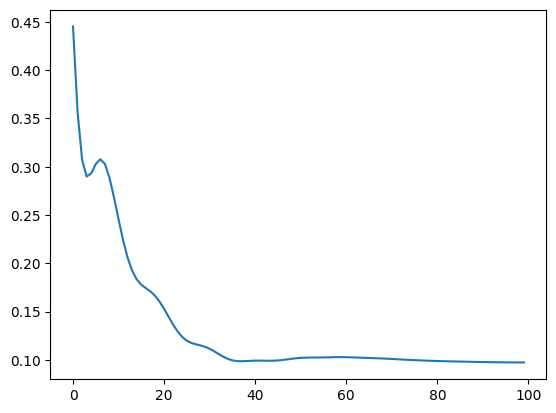

fNet(
  (layer1): Linear(in_features=2, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=2, bias=True)
)

In [20]:
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

# Model
model_f = fNet(nn_x, nn_h_f, nn_x)
model_v = Net(D_in,H1, D_out)

loss_fn = nn.MSELoss()  # mean square error
optimizer_f = torch.optim.Adam(model_f.parameters(), lr = lr_warm)
optimizer_v = torch.optim.Adam(model_v.parameters(), lr = lr_warm)

for epoch in range(n_epochs):
    model_f.train()
    model_v.train()
    # Calculate the loss
    loss = lossfunction_warm(X_train, y_train, model_v, model_f)
    # backward pass
    optimizer_f.zero_grad()
    optimizer_v.zero_grad()
    loss.backward() 
    optimizer_f.step()
    optimizer_v.step()
    #evaluate accuracy at end of each epoch
    model_f.eval()
    model_v.eval()
    y_pred = model_f(X_test)
    mse = lossfunction_warm(X_test, y_test, model_v, model_f)
    mse = float(mse)
    history.append(mse)
    if loss < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model_f.state_dict())
    with torch.no_grad():
        torch.cuda.empty_cache()
# restore model and return best accuracy
model_f.load_state_dict(best_weights)
print("MSE: %.4f" % best_mse)
print("RMSE: %.4f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()
model_f.eval()

## Taking Train Dataset Whole

In [27]:
out_iters = 0
valid = False
while out_iters < 2 and not valid: 
    start = timeit.default_timer()
    model_v = Net(D_in,H1, D_out)
    L = []
    i = 0 
    t = 0
    max_iters = 5000 # increase number of epoches if cannot find a valid LF
    optimizer_v = torch.optim.Adam(model_v.parameters(), lr=learning_rate)

    while i < max_iters and not valid: 
        # Calculate the loss
        x = x.float()
        x = x
        # Value of Lyapunov Model
        V_candidate = model_v(x)
        X0 = model_v(x_0)
        # Value of Function Model
        f = model_f(x)
        Circle_Tuning = Tune(x)
        Circle_Tuning = Circle_Tuning
        # Compute lie derivative of V : L_V = ∑∂V/∂xᵢ*fᵢ
        L_V = torch.diagonal(torch.mm(torch.mm(torch.mm(dtanh(V_candidate),model_v.layer2.weight)\
                            *dtanh(torch.tanh(torch.mm(x,model_v.layer1.weight.t())+model_v.layer1.bias)),model_v.layer1.weight),f.t()),0)
        
        dVdx = torch.mm(torch.mm(dtanh(V_candidate),model_v.layer2.weight)\
                            *dtanh(torch.tanh(torch.mm(x,model_v.layer1.weight.t())+model_v.layer1.bias)),model_v.layer1.weight)
                
        # MSE Loss
        L1 = loss_fn(model_f(X_train),y_train)
                
        # Needs to be tuned
        Lyapunov_risk = (F.relu(-V_candidate)+ 1.2*F.relu(L_V+0.2)).mean() +0.5 * ((Circle_Tuning-V_candidate).pow(2)).mean() + 5*(X0).pow(2) + 0.01*torch.norm(dVdx) + 3 * L1
 
        L.append(Lyapunov_risk.item())
        optimizer_v.zero_grad()
        optimizer_f.zero_grad()
        Lyapunov_risk.backward()
        optimizer_v.step() 
        optimizer_f.step() 

        print(f"{i}) Lyapunov Risk = {Lyapunov_risk.item()}, MSE = {L1}, V_0_loss = {(X0).pow(2).float()}, V_pos_loss = {F.relu(-V_candidate).mean()}, Lv_loss = {F.relu(L_V).mean()}, Circular Tuning Loss = {((Circle_Tuning-V_candidate).pow(2)).mean()}")
        # Finding the values for the new model function
        f_w1 = model_f.layer1.weight.data.cpu().numpy()
        f_w2 = model_f.layer2.weight.data.cpu().numpy()
        f_b1 = model_f.layer1.bias.data.cpu().numpy()
        f_b2 = model_f.layer2.bias.data.cpu().numpy()

        f_h1 = []
        f_z1 = np.dot(vars_,f_w1.T)+f_b1
        for n in range(len(f_z1)):
            f_h1.append(tanh(f_z1[n]))
        f_learn = np.dot(f_h1,f_w2.T)+f_b2
        # save the weights and biases 
        w1 = model_v.layer1.weight.data.cpu().numpy()
        w2 = model_v.layer2.weight.data.cpu().numpy()
        b1 = model_v.layer1.bias.data.cpu().numpy()
        b2 = model_v.layer2.bias.data.cpu().numpy()
        
        # Falsification with SMT solver
        if i % 10 == 0:
                    
            # Candidate V
            z1 = np.dot(vars_,w1.T)+b1
        
            a1 = []
            for j in range(0,len(z1)):
                a1.append(tanh(z1[j]))
            z2 = np.dot(a1,w2.T)+b2
            V_learn = tanh(z2.item(0))
        
            print('===========Verifying==========')        
            start_ = timeit.default_timer() 
            #beta = -np.maximum(beta, -0.02) # in case beta is too negative and cannot return any results
            result= CheckLyapunov(vars_, f_learn, V_learn, ball_lb, ball_ub, config, beta) # SMT solver
            stop_ = timeit.default_timer() 
        
            if (result): 
                    print("Not a Lyapunov function. Found counterexample: ")
                    print(result)
                    x = x.to('cpu')
                    x = AddCounterexamples(x,result,10)
            else:  
                    # # calculate norm of dVdx with the SMT solver
                    # M = 0.05 # lower bound of M
                    # dvdx_bound = np.sqrt(M)
                    # violation = CheckdVdx(vars_, V_learn, ball_ub, config, M) 
                    # while violation:
                    #     violation = CheckdVdx(vars_, V_learn, ball_ub, config, M)
                    #     if not violation:
                    #         dvdx_bound = np.sqrt(M)
                    #         print(dvdx_bound, "is the norm of dVdx")
                    #     M += 0.001
                    # beta = -dvdx_bound*((Kf+KF)*d+loss) # update beta 
                    # print("Satisfies with a non-strict condition")
                    # result_strict= CheckLyapunov(vars_, f_learn, V_learn, ball_lb, ball_ub, config, beta) # SMT solver
                    # beta = beta.detach().numpy()
                    # if not result_strict:
                    #     valid = True
                    #     print("Satisfy conditions with beta = ", beta)
                    #     print(V_learn, " is a Lyapunov function.")
                    valid = True
                    print("Satisfy conditions")
                    print(V_learn, " is a Lyapunov function.")
            t += (stop_ - start_)
            print('==============================') 
        i += 1

    stop = timeit.default_timer()
    
    np.savetxt("w1_vdp.txt", model_v.layer1.weight.data.cpu(), fmt="%s")
    np.savetxt("w2_vdp.txt", model_v.layer2.weight.data.cpu(), fmt="%s")
    np.savetxt("b1_vdp.txt", model_v.layer1.bias.data.cpu(), fmt="%s")
    np.savetxt("b2_vdp.txt", model_v.layer2.bias.data.cpu(), fmt="%s")

    print('\n')
    print("Total time: ", stop - start)
    print("Verified time: ", t)
    
    out_iters+=1

0) Lyapunov Risk = 2.0600757598876953, MSE = 0.09029114991426468, V_0_loss = tensor([[0.0065]], grad_fn=<PowBackward0>), V_pos_loss = 0.21220408380031586, Lv_loss = 0.25860708951950073, Circular Tuning Loss = 1.8393646478652954
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.00010000000000000002, 0.00010000000000000002]
x2 : [-0.00010000000000000002, 0.00010000000000000002]
1) Lyapunov Risk = 2.032743453979492, MSE = 0.09097481518983841, V_0_loss = tensor([[0.0064]], grad_fn=<PowBackward0>), V_pos_loss = 0.2106582522392273, Lv_loss = 0.24444378912448883, Circular Tuning Loss = 1.8203381299972534
2) Lyapunov Risk = 2.010293960571289, MSE = 0.09406661242246628, V_0_loss = tensor([[0.0064]], grad_fn=<PowBackward0>), V_pos_loss = 0.2104136049747467, Lv_loss = 0.22317993640899658, Circular Tuning Loss = 1.8194581270217896
3) Lyapunov Risk = 1.9892088174819946, MSE = 0.09878548979759216, V_0_loss = tensor([[0.0063]], grad_fn=<PowBackward0>), V_pos_loss

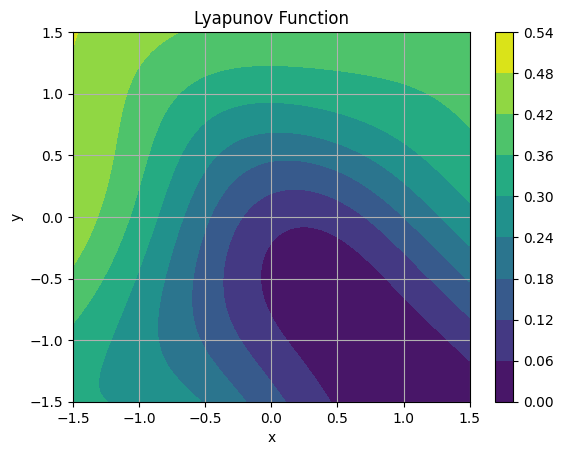

In [28]:
# Plotting the Lyapunov Function
fig, ax = plt.subplots()
# Define grid for plotting
len_sample = [256, 256]
x = np.linspace(region[0], region[1], len_sample[0])
y = np.linspace(region[0], region[1], len_sample[1])
X, Y = np.meshgrid(x, y)

# Convert X and Y to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Concatenate X and Y to create input data tensor
input_data = torch.stack((X_tensor, Y_tensor), dim=-1).reshape(-1, 2)
unflatten = torch.nn.Unflatten(0, len_sample)

# Lyapunov Function
with torch.no_grad():
    V = model_v(input_data)
    cont_out = unflatten(V)
    cont_out = cont_out.detach().numpy()
# Plot the vector field
cp = ax.contourf(X, Y, cont_out[:,:,0])
fig.colorbar(cp)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lyapunov Function')
plt.show()

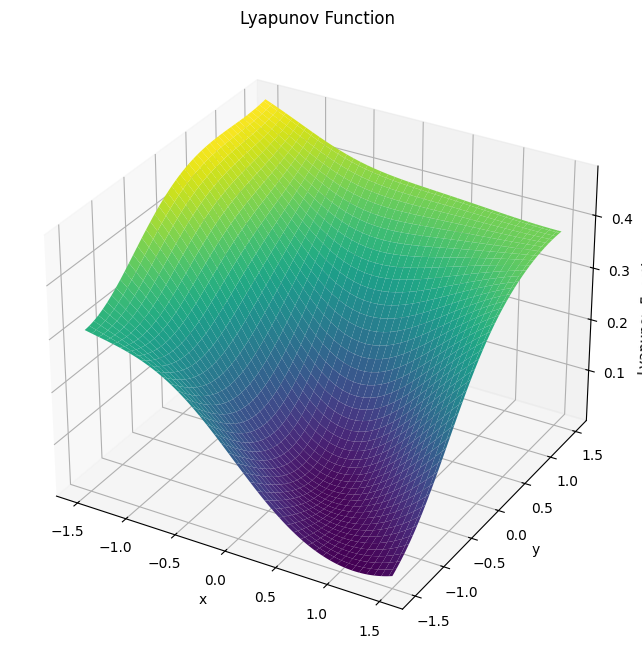

In [29]:
# Plot the Lyapunov function in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, cont_out[:,:,0], cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Lyapunov Function Value')
ax.set_title('Lyapunov Function')
plt.show()

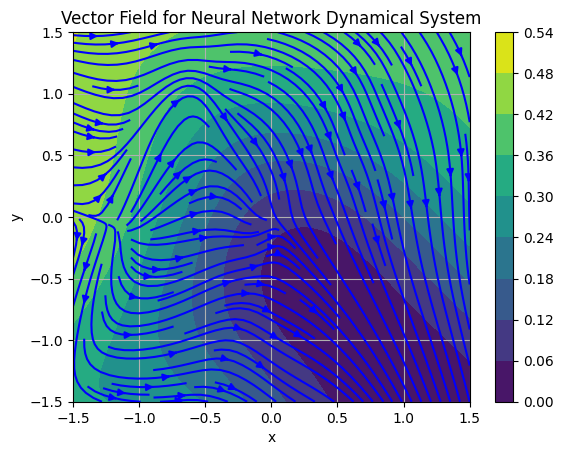

In [30]:
fig, ax = plt.subplots()
# Define grid for plotting
len_sample = [256, 256]
x = np.linspace(region[0], region[1], len_sample[0])
y = np.linspace(region[0], region[1], len_sample[1])
X, Y = np.meshgrid(x, y)

# Convert X and Y to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Concatenate X and Y to create input data tensor
input_data = torch.stack((X_tensor, Y_tensor), dim=-1).reshape(-1, 2)
unflatten = torch.nn.Unflatten(0, len_sample)

# Vector Field
with torch.no_grad():
    F = model_f(input_data)
    vect_out = unflatten(F)
    vect_out = vect_out.detach().numpy()
    U = vect_out[:,:, 0]
    V = vect_out[:,:,1]
ax.streamplot(X, Y, U, V, density=1.4, linewidth=None, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector Field for Neural Network Dynamical System')

# Lyapunov Function
with torch.no_grad():
    V = model_v(input_data)
    cont_out = unflatten(V)
    cont_out = cont_out.detach().numpy()
# Plot the vector field
cp = ax.contourf(X, Y, cont_out[:,:,0])
fig.colorbar(cp)
plt.grid(True)
plt.show()

## Plot the Training Trajectories and the Output Trajectory taken by the model

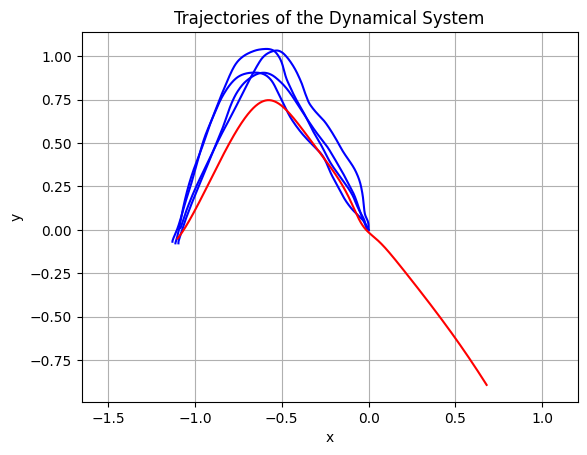

In [31]:
# Plotting the Training Data
fig, ax = plt.subplots()
n = int(X_train.shape[0]/1000)
for i in range(5):
    ax.plot(X_train[(i-1)*1000+1:i*1000,0], X_train[(i-1)*1000+1:i*1000,1],"b")

# Plotting the final trajectory
n = 1000
x = torch.zeros((n, 2))
x[0] = torch.tensor([-1.1,-0.05], dtype=torch.float32)
for j in range(1, n):
    x[j] = x[j-1] + model_f(x[j-1]) * dt
x = x.detach().numpy()
ax.plot(x[:, 0], x[:, 1],'r')

# Plotting the origin
#plt.plot(0, 0, 'ro')
#plt.text(0.1, 0.1, 'Origin (0, 0)', fontsize=10)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories of the Dynamical System')
plt.grid(True)
plt.axis('equal')
plt.show()